Dataset: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset/download?datasetVersionNumber=1

Objective: Build a binary classifier that predicts if a bank’s customer is going to churn or not.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [2]:
# Read the dataset and display columns.
df_original = pd.read_csv('dataset/data.csv')
df_original.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# df.info() shows the data type of each column and the number of non-null values.
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
# df.value_counts() shows the number of non-null values for each column.
print("Country value counts:")
print(df_original['country'].value_counts())
print("---------------------------------")
print("Gender value counts:")
print(df_original['gender'].value_counts())
print("---------------------------------")
print("Churn value counts:")
print(df_original['churn'].value_counts())

Country value counts:
country
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
---------------------------------
Gender value counts:
gender
Male      5457
Female    4543
Name: count, dtype: int64
---------------------------------
Churn value counts:
churn
0    7963
1    2037
Name: count, dtype: int64


### We can see that the dataset is imbalanced.

In [5]:
# df.describe() shows a statistical summary of the dataset.
df_original.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


From the dataset we can see that:
- The variable *customer_id* is a unique identifier for each customer.
- The variable *churn* is the target variable.
- The rest of the variables are either categorical or numerical.

In [6]:
# transform categorical data to numeric data
df = pd.get_dummies(df_original)
df.head()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,True,False,False,True,False
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,True,False
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,True,False,False,True,False
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,True,False,False,True,False
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,True,False


<Axes: >

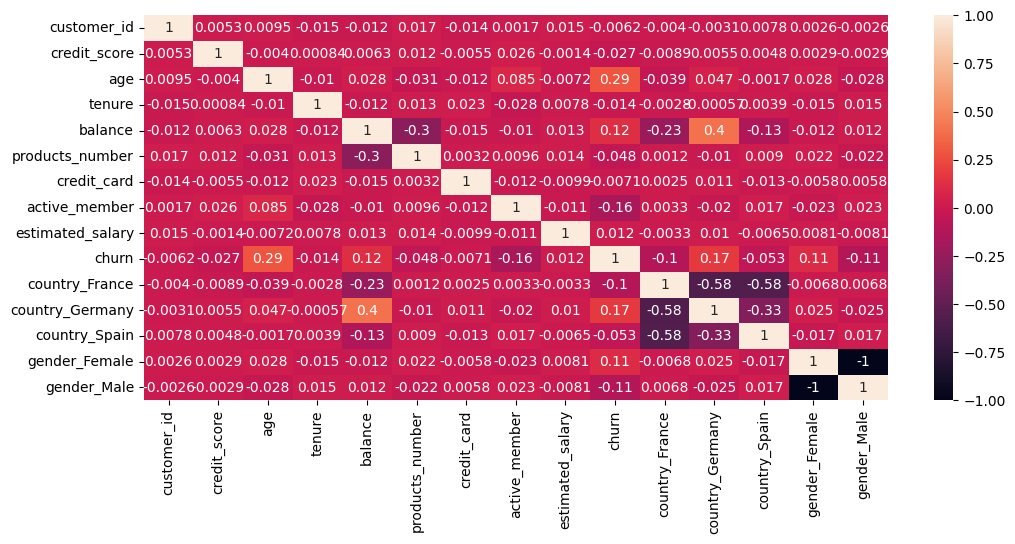

In [7]:
# We can calculate the correlation between the numeric features of the dataset.
# The result is a table with values between -1 and 1.
corr = df.corr(numeric_only=True)

# We can also plot the correlation between the numeric features of the dataset.
fig = plt.figure(figsize=(12, 5))
sns.heatmap(corr, annot=True)

In [8]:
# show the correlation of the target variable with the other variables
corr_target = corr['churn']
# We can sort the correlation values in descending order.
corr_target = corr_target.sort_values(ascending=False)
print(corr_target)

churn               1.00
age                 0.29
country_Germany     0.17
balance             0.12
gender_Female       0.11
estimated_salary    0.01
customer_id        -0.01
credit_card        -0.01
tenure             -0.01
credit_score       -0.03
products_number    -0.05
country_Spain      -0.05
country_France     -0.10
gender_Male        -0.11
active_member      -0.16
Name: churn, dtype: float64


*age* has the highest correlation with churn, so we can say that the older the customer is, the more likely he/she is to churn.

### Create training and test sets.

In [9]:
# We can use the drop() method to drop the columns that we don't need.
X = df.drop(['customer_id', 'churn'], axis=1)
y = df['churn']

# We can use the train_test_split() method to split the dataset into training and testing sets.
# The test_size parameter specifies the percentage of the dataset that will be used for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_France,country_Germany,country_Spain,gender_Female,gender_Male
316,559,49,2,147069.78,1,1,0,120540.83,True,False,False,False,True
6834,703,50,8,160139.59,2,1,1,79314.10,True,False,False,False,True
5023,555,40,10,43028.77,1,1,0,170514.21,True,False,False,False,True
1097,543,36,6,0.00,2,1,0,176728.28,True,False,False,False,True
5054,640,36,4,0.00,1,0,0,173016.46,False,False,True,False,True


### Train a Machine Learning model to predict if a customer is going to churn.


In [10]:
# We can use the LazyClassifier() method to train all the models in the Scikit-learn library.
model = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

models = model.fit(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

100%|██████████| 29/29 [00:08<00:00,  3.56it/s]


### Evaluate your model on the test set, describing the metrics you are using and why you are using them. Comment on the results.

In [11]:
# We can print the results of each model with the following metrics:
# The Accuracy is the percentage of correct predictions.
# The Balanced Accuracy is the average of recall obtained on each class.
# The ROC AUC Score is the area under the ROC curve.
# The F1 score is the harmonic mean of precision and recall.
models[0].sort_values(by=['F1 Score'], ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.86,0.71,0.71,0.85,0.08
XGBClassifier,0.85,0.70,0.70,0.84,0.30
RandomForestClassifier,0.86,0.69,0.69,0.84,0.87
BaggingClassifier,0.85,0.70,0.70,0.84,0.25
ExtraTreesClassifier,0.85,0.68,0.68,0.84,0.54
AdaBoostClassifier,0.85,0.69,0.69,0.83,0.30
SVC,0.85,0.67,0.67,0.83,1.12
KNeighborsClassifier,0.84,0.67,0.67,0.82,0.10
QuadraticDiscriminantAnalysis,0.84,0.63,0.63,0.81,0.01


<Axes: title={'center': 'Models F1 Score'}, xlabel='F1 Score', ylabel='Model'>

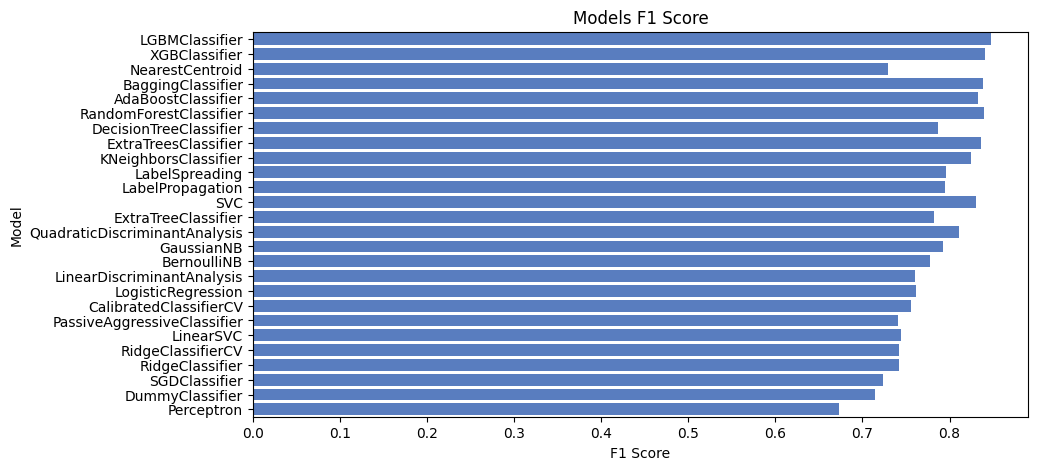

In [12]:
# print a chart with the results every model with matplotlib
plt.figure(figsize=(10, 5))
plt.title('Models F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Model')
sns.set_color_codes("muted")
sns.barplot(y=models[0]['F1 Score'].keys(), x=models[0]['F1 Score'], color="b")

### From the results we can see that even the Dummy Classifier has an **Accuracy** of 0.79 because the *churn* variable is imbalanced.